In [1]:
#!pip install huffman

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import misc, ndimage
from scipy.fft import dctn, idctn
import cv2
import huffman
from collections import Counter
import os

In [19]:
Q_jpeg = [[16, 11, 10, 16, 24, 40, 51, 61],
          [12, 12, 14, 19, 26, 28, 60, 55],
          [14, 13, 16, 24, 40, 57, 69, 56],
          [14, 17, 22, 29, 51, 87, 80, 62],
          [18, 22, 37, 56, 68, 109, 103, 77],
          [24, 35, 55, 64, 81, 104, 113, 92],
          [49, 64, 78, 87, 103, 121, 120, 101],
          [72, 92, 95, 98, 112, 100, 103, 99]]

zigzag_template = [
        (0, 0), (0, 1), (1, 0), (2, 0), (1, 1), (0, 2), (0, 3), (1, 2),
        (2, 1), (3, 0), (4, 0), (3, 1), (2, 2), (1, 3), (0, 4), (0, 5),
        (1, 4), (2, 3), (3, 2), (4, 1), (5, 0), (6, 0), (5, 1), (4, 2),
        (3, 3), (2, 4), (1, 5), (0, 6), (0, 7), (1, 6), (2, 5), (3, 4),
        (4, 3), (5, 2), (6, 1), (7, 0), (7, 1), (6, 2), (5, 3), (4, 4),
        (3, 5), (2, 6), (1, 7), (2, 7), (3, 6), (4, 5), (5, 4), (6, 3),
        (7, 2), (7, 3), (6, 4), (5, 5), (4, 6), (3, 7), (4, 7), (5, 6),
        (6, 5), (7, 4), (7, 5), (6, 6), (5, 7), (6, 7), (7, 6), (7, 7)]


def matrix_to_zigzag(m):
    zigzag_iteration = [m[i, j] for i, j in zigzag_template]
    return zigzag_iteration


def zigzag_to_matrix(l):
    m = np.zeros((8, 8))
    for i in range(64):
        r, c = zigzag_template[i]
        m[r, c] = int(l[i])
    return m    




In [20]:
# sarcina 1
def jpeg_encoding(X):
    r, c = X.shape
    r8 = int(np.ceil(r/8) * 8)
    c8 = int(np.ceil(c/8) * 8)
    
    padding_r = r8 - r 
    padding_c = c8 - c
    
    X_ext = cv2.copyMakeBorder(X, 0, padding_c, 0, padding_r, cv2.BORDER_CONSTANT, value=0)

    # luam pe rand fiecare bloc de 8x8 
    # ii facem dctn + cuantizare
    # parcurgem blocul in zig zag si concatenam raspunsurile de la fiecare bloc
    # aplicam huffman pe sirul concatenat

    zigzag_concatenat = []

    for i in range(int(r8/8)):
        for j in range(int(c8/8)):
            # extragerea blocului:
            x = X_ext[8*i:8*i + 8, 8*j:8*j + 8]

            # aplicarea dctn:
            y = dctn(x)

            # cuantizare:
            y_jpeg = Q_jpeg*np.round(y/Q_jpeg)
            # parcurgere zigzag:
            y_zigzag = matrix_to_zigzag(y_jpeg)
            
            # concatenare rezultat:
            zigzag_concatenat.extend(y_zigzag)

    # TODO: Huffman coding
    
    return list(map(int, zigzag_concatenat)), r8, c8



def jpeg_decoding(encoded_data, r, c):
    # TODO: Huffman decoding
    
    X_jpeg = np.zeros((r, c))
    matrix_list = []
    for i in range(int(len(encoded_data)/64)):
        y = zigzag_to_matrix(encoded_data[i*64 : i*64+64])
        x_jpeg = idctn(y)

        matrix_list.append(x_jpeg)
    count = 0
    for i in range(int(r/8)):
        for j in range(int(c/8)):
            X_jpeg[8*i:8*i + 8, 8*j:8*j + 8] = matrix_list[count]
            count += 1
    
    return X_jpeg    

In [21]:
# codare si decodare pentru imagini color (sarcina 2)

def jpeg_color_encoding(X, subsampling_type="4:4:4"):

    # conversia de la RGB la YCrCb
    X = cv2.cvtColor(X, cv2.COLOR_BGR2YCR_CB)
    
    r, c, _ = X.shape
    r8 = int(np.ceil(r/8) * 8)
    c8 = int(np.ceil(c/8) * 8)
    
    padding_r = r8 - r 
    padding_c = c8 - c
    
    X_ext = cv2.copyMakeBorder(X, 0, padding_c, 0, padding_r, cv2.BORDER_CONSTANT, value=[0,0,0])

    Y, Cr, Cb = cv2.split(X_ext)

    if subsampling_type == "4:4:4":
        Cb_subs = Cb
        Cr_subs = Cr
    elif subsampling_type == "4:2:2":
        # orizontal
        Cb_subs = Cb[:, ::2]
        Cr_subs = Cr[:, ::2]
    elif subsampling_type == "4:2:0":
        # vertical + orizontal
        Cb_subs = Cb[::2, ::2]
        Cr_subs = Cr[::2, ::2]
    else:
        raise ValueError("Subsampling gresit. este permis doar 4:4:4, 4:2:2 sau 4:2:0")
    
    if subsampling_type != "4:4:4":
        Cb = cv2.resize(Cb_subs, (Cb.shape[1], Cb.shape[0]), interpolation=cv2.INTER_LINEAR)
        Cr = cv2.resize(Cr_subs, (Cr.shape[1], Cr.shape[0]), interpolation=cv2.INTER_LINEAR)

    X_ext = cv2.merge((Y, Cr, Cb))
    zigzag_concatenat = [] 

    for i in range(int(r8/8)):
        for j in range(int(c8/8)):
            # extragerea blocului:
            x = X_ext[8*i:8*i + 8, 8*j:8*j + 8]

            x_y, x_cr, x_cb = cv2.split(x)

            # aplicarea dctn:
            y_y = dctn(x_y)
            y_cr = dctn(x_cr)
            y_cb = dctn(x_cb)

            # cuantizare:
            y_y_jpeg = Q_jpeg*np.round(y_y/Q_jpeg)
            y_cr_jpeg = Q_jpeg*np.round(y_cr/Q_jpeg)
            y_cb_jpeg = Q_jpeg*np.round(y_cb/Q_jpeg)

            # parcurgere zigzag:
            y_y_zigzag = matrix_to_zigzag(y_y_jpeg)
            y_cr_zigzag = matrix_to_zigzag(y_cr_jpeg)
            y_cb_zigzag = matrix_to_zigzag(y_cb_jpeg)
            
            # concatenare rezultat:
            zigzag_concatenat.extend(y_y_zigzag)
            zigzag_concatenat.extend(y_cr_zigzag)
            zigzag_concatenat.extend(y_cb_zigzag)

    # TODO: Huffman coding

    return list(map(int, zigzag_concatenat)), r8, c8



def jpeg_color_decoding(encoded_data, r, c):
    # TODO: Huffman decoding
    
    X_jpeg = np.zeros((r, c, 3))
    matrix_list = []
    for i in range(int(len(encoded_data)/192)):
        block = encoded_data[i*192 : i*192+192]
        
        y_y = zigzag_to_matrix(block[:64])
        y_cr = zigzag_to_matrix(block[64:128])
        y_cb = zigzag_to_matrix(block[128:])
        
        x_y_jpeg = np.maximum(0, idctn(y_y))
        x_cr_jpeg = np.maximum(0, idctn(y_cr))
        x_cb_jpeg = np.maximum(0, idctn(y_cb))

        x_y_jpeg = x_y_jpeg.astype(int)
        x_cr_jpeg = x_cr_jpeg.astype(int)
        x_cb_jpeg = x_cb_jpeg.astype(int)
        
        x_jpeg = cv2.merge((x_y_jpeg, x_cr_jpeg, x_cb_jpeg))
        
        matrix_list.append(x_jpeg)
    count = 0
    for i in range(int(r/8)):
        for j in range(int(c/8)):
            X_jpeg[8*i:8*i + 8, 8*j:8*j + 8] = matrix_list[count]
            count += 1
    X_jpeg = np.clip(X_jpeg, 0, 255).astype(np.uint8)
    X_jpeg = cv2.cvtColor(X_jpeg, cv2.COLOR_YCrCb2BGR)
    return X_jpeg





In [22]:
# sarcina 3
def compute_mse(X_origin, X_jpeg):
    # aducem imaginile la acelasi shape 
    # (in unele cazuri shape ul lui X_jpeg poate fi mai mare din cauza padding ului)
    X_origin_ext = np.zeros_like(X_jpeg)
    X_origin_ext = X_origin_ext + X_origin
    return np.sum((X_origin_ext - X_jpeg) ** 2) / (X_jpeg.shape[0] * X_jpeg.shape[1])



In [25]:
# sarcina 4
def extract_frames(video_path, output_folder):
    
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    cap = cv2.VideoCapture(video_path)

    if not cap.isOpened():
        print("Error: Cannot open video.")
        return

    frames = []
    
    frame_count = 0
    for _ in range(10):
        ret, frame = cap.read()
        if not ret:
            print("End of video.")
            break
        
        frame_filename = os.path.join(output_folder, f"frame_{frame_count:04d}.jpg")
        cv2.imwrite(frame_filename, frame)

        encoded_frame, r, c = jpeg_color_encoding(frame)
        frames.append(encoded_frame)        
        frame_count += 1

    cap.release()
    
    return frames, r, c


In [ ]:

video_path = "highway.mp4"
output_folder = "frames"
frames, r, c = extract_frames(video_path, output_folder)
for frame in frames:
    decoded_frame = jpeg_color_decoding(frame, r, c)
    plt.imshow(decoded_frame)
    plt.show()




C:\Users\maria\AppData\Local\Temp\ipykernel_18152\2385025700.py:2: DeprecationWarning: scipy.misc.face has been deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. Dataset methods have moved into the scipy.datasets module. Use scipy.datasets.face instead.
  X = misc.face()


8.163888295491537


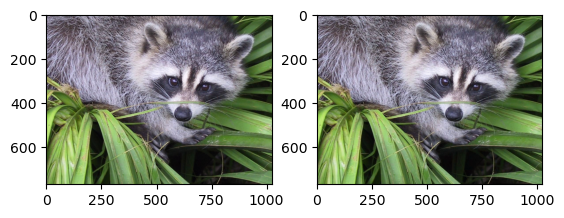

In [9]:
# X = misc.ascent()
X = misc.face()

encoded_data, r, c = jpeg_color_encoding(X, "4:2:0")
decoded_data = jpeg_color_decoding(encoded_data, r, c)

print(compute_mse(X, decoded_data))

plt.subplot(121).imshow(X)
plt.subplot(122).imshow(decoded_data)
plt.show()


# plt.subplot(121).imshow(X, cmap=plt.cm.gray)
# plt.subplot(122).imshow(decoded_data, cmap=plt.cm.gray)
# plt.show()